In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import dateutil.parser as dparser

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
session.query(func.count(measurement.date)).all()

[(19550)]

In [13]:
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

In [14]:
last_point  = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_point = str(last_point)
last_point = dparser.parse(last_point,fuzzy=True)
last_point

datetime.datetime(2017, 8, 23, 0, 0)

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date_last12 = last_point - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
date_prcp = [measurement.date, measurement.prcp]
last12_prcp = session.query(*date_prcp).filter(measurement.date >= date_last12).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(last12_prcp, columns = ["date", "precipitation"])
prec_df.set_index(prec_df["date"], inplace = True)

# Sort the dataframe by date
prec_df.sort_index()


,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15
...,...,...
2017-08-22,2017-08-22,0.00
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


In [16]:
prec_df.head()

,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-24,2016-08-24,0.08
2016-08-25,2016-08-25,0.08
2016-08-26,2016-08-26,0.00
2016-08-27,2016-08-27,0.00


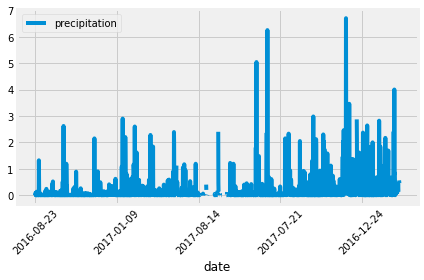

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(rot = 45)
plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
pd.read_sql_query('SELECT COUNT(station) FROM station', con = engine)

,COUNT(station)
0,9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
pd.read_sql_query('SELECT station, COUNT(station) as CS FROM measurement \
    GROUP BY station ORDER BY CS DESC', con = engine)

,station,CS
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
pd.read_sql_query("SELECT MAX (tobs) as highest_temp, MIN (tobs) as lowest_temp, AVG(tobs) as avg_temp \
FROM measurement WHERE station = 'USC00519281'", con = engine)

,highest_temp,lowest_temp,avg_temp
0,85.0,54.0,71.663781


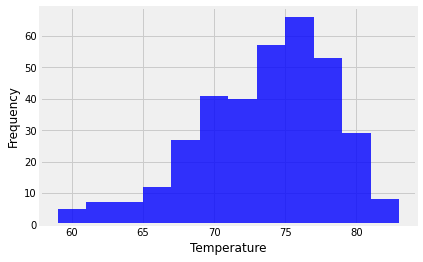

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp = [measurement.tobs]

topstation = session.query(*temp).filter_by(station = "USC00519281")\
.filter(measurement.date >= date_last12).all()

ts = pd.DataFrame(topstation, columns = ["temp"])

plt.hist(ts["temp"],bins = 12, facecolor="blue", alpha = 0.8)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2016-07-02'
end = '2016-07-17'
temperatures = calc_temps(start, end)
temperatures

[(71.0, 77.07070707070707, 82.0)]

Text(0, 0.5, 'Temperatures (F)')

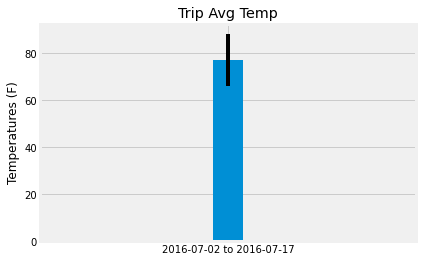

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = temperatures [0][0]
tavg = temperatures [0][1]
tmax = temperatures [0][2]

y_error = tmax - tmin

trip_duration = "2016-07-02 to 2016-07-17"

plt.bar(trip_duration, tavg, yerr=y_error)
plt.xlim(-5,5)
plt.title("Trip Avg Temp")
plt.ylabel("Temperatures (F)")

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
